Let’s work through the implementation using PyTorch to generate Monet-style images for the Kaggle competition, focusing on a dataset of Monet paintings and another dataset of photos. We’ll follow these steps:

1. **Understanding the Dataset**: We’ll explore the dataset structure and understand its content.
2. **Creating PyTorch Datasets and DataLoaders**: We’ll create PyTorch datasets and data loaders, explaining their importance.
3. **Visualizing a Few Samples**: We’ll visualize some samples and explain the concept of unpaired images and the importance of CycleGAN.

In [1]:
!pip install torchmetrics[image] -q

# 1. Understanding the Dataset

In this task, we have two main datasets:

- **Monet Paintings**: A collection of images created by Claude Monet, representing the target style we aim to replicate.
- **Photos**: A set of regular photographs that we want to transform into the Monet painting style.

**Key Points**:
- **Unpaired Data**: The Monet paintings and photos do not have a direct correspondence (i.e., no paired data like a photo and its Monet-style counterpart).
- **Objective**: To learn a mapping from the domain of photos to the domain of Monet paintings using unpaired data.

In [2]:
import os
import time
import numpy as np
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
# Set seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:

# Import Config class
from dataclasses import dataclass

@dataclass
class Config:
    # General training parameters
    num_epochs: int = 200
    batch_size = 4
    num_workers = 4
    
    # Logging parameters
    log_file: str = '/kaggle/working/training.log'
    
    # Model and optimizer parameters (example placeholders)
    learning_rate: float = 0.001
    weight_decay: float = 1e-5
        
    # Model and optimizer parameters
    G_lr: float = 0.0002
    D_lr: float = 0.0002
    betas_G: tuple = (0.5, 0.999)
    betas_D_X: tuple = (0.5, 0.999)
    betas_D_Y: tuple = (0.5, 0.999)
    
    # Threshold for MiFID calculation
    mifid_threshold: float = 0.1

# Initialize Config instance
config = Config()

In [5]:
import logging

# Set up logging
logging.basicConfig(
    filename=config.log_file,
    format='%(asctime)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.INFO
)



# 2. Creating PyTorch Datasets and DataLoaders

PyTorch datasets and data loaders are essential for efficiently handling and processing large datasets during training. They support batching, shuffling, and parallel data loading, which are crucial for training neural networks effectively.

#### Creating the Dataset Class

We’ll define a custom dataset class for loading images from both domains (Monet paintings and photos) and applying necessary transformations like resizing and normalization.

In [6]:
# Dataset class
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [7]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
# Create datasets for Monet paintings and photos
monet_path = "/kaggle/input/gan-getting-started/monet_jpg"
photos_path = "/kaggle/input/gan-getting-started/photo_jpg"

monet_dataset = ImageDataset(root_dir=monet_path, transform=transform)
photo_dataset = ImageDataset(root_dir=photos_path, transform=transform)

In [9]:
len(monet_dataset), len(photo_dataset)

(300, 7038)

#### Creating DataLoaders

Data loaders are used to handle batch loading, shuffling, and parallel data loading, which are important for efficient training.

**Importance of DataLoaders**:
- **Batching**: Processes multiple images in each iteration, speeding up training and helping with generalization.
- **Shuffling**: Ensures that the model doesn’t memorize the order of images, promoting better learning.
- **Parallel Loading**: Uses multiple CPU cores for data loading, reducing the time needed to load data and increasing training efficiency.

In [10]:
# Create data loaders
monet_loader = DataLoader(monet_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)
photo_loader = DataLoader(photo_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)

# 3. Visualizing a Few Samples and Explaining CycleGAN

#### Visualizing a Few Samples

Visualizing samples helps us understand the dataset and verify that our data preprocessing steps are working correctly.

In [11]:
# Function to show images
def show_images(images, title=None):
    fig, ax = plt.subplots(1, len(images), figsize=(15, 5))
    if title:
        fig.suptitle(title, fontsize=16)
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]
        img = img * 0.5 + 0.5  # Denormalize
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [12]:
# Get some images
monet_iter = iter(monet_loader)
photo_iter = iter(photo_loader)

monet_images = [next(monet_iter) for _ in range(4)]
photo_images = [next(photo_iter) for _ in range(4)]

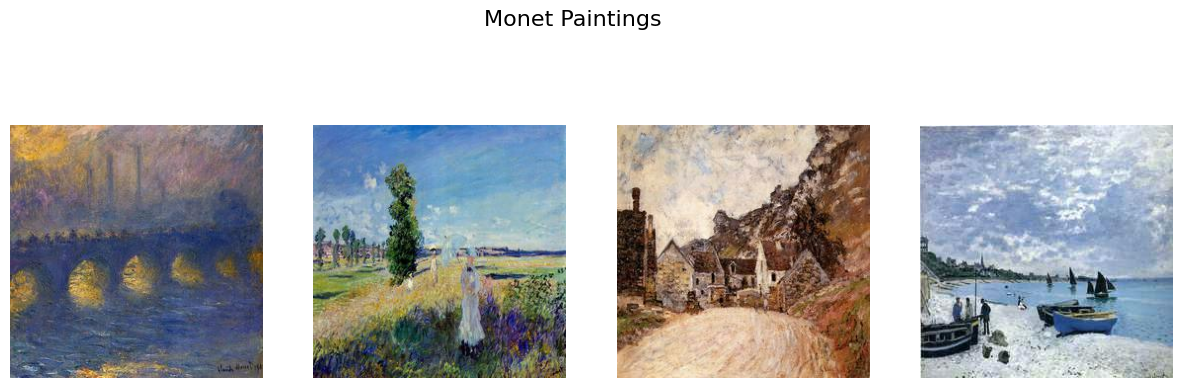

In [13]:
show_images([monet_images[i][0] for i in range(4)], title='Monet Paintings')

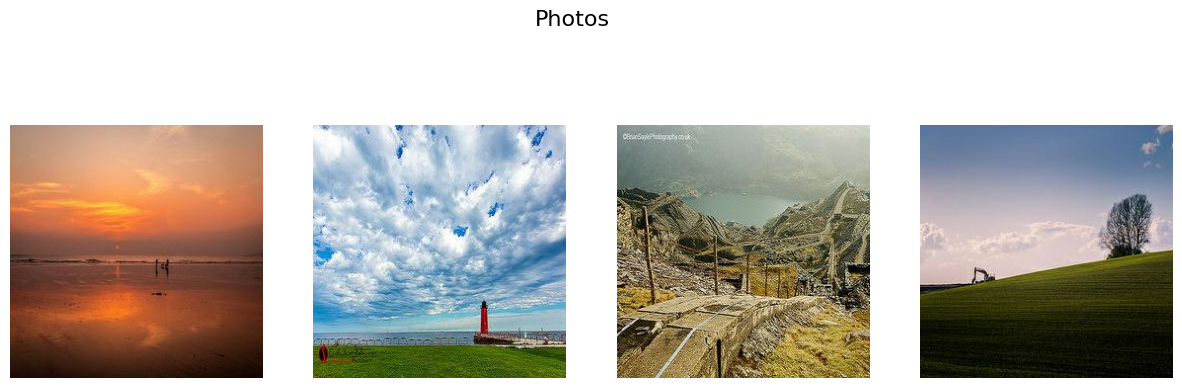

In [14]:
show_images([photo_images[i][0] for i in range(4)], title='Photos')

This implementation provides a thorough approach to loading, processing, and visualizing your datasets, laying a strong foundation for developing and training a CycleGAN to translate photos into Monet-style paintings.

#### Explanation of Unpaired Images and CycleGAN

**Unpaired Images**:
- In many real-world scenarios, we don’t have direct pairs of images from two different domains. For example, we don’t have a direct photograph and its corresponding Monet-style painting.
- Unpaired datasets consist of two separate sets of images (e.g., Monet paintings and photos) without direct correspondences between them.

**Importance of CycleGAN**:
- **Bidirectional Mapping**: CycleGAN maps images from the domain of photos to the domain of Monet paintings and vice versa. This ensures the generated images look realistic and retain the structural integrity of the original photos.
- **Cycle Consistency**: The cycle consistency loss in CycleGAN ensures that an image can be translated to another domain and back to its original form, preserving essential content and structure.
- **Style Transfer**: CycleGAN is designed to learn the artistic style of one set of images (Monet paintings) and apply it to another set (photos), making it ideal for tasks like creating Monet-style images from regular photos.

By visualizing the samples, we can appreciate the diversity in the datasets and understand the challenge of translating between two distinct image domains. This visualization also ensures our data loaders and preprocessing steps are functioning correctly, setting the stage for developing and training a CycleGAN.

Let's proceed with building and training a CycleGAN to translate photos into Monet-style paintings using PyTorch. We’ll cover the following steps:

1. **Build a Simple Baseline CycleGAN Architecture**: We’ll implement the generator and discriminator models and explain our choices.
2. **Train and Evaluate the Model**: We’ll train the CycleGAN on the Monet and photo datasets, providing explanations for the training process and evaluation.

### 1. Build a Simple Baseline CycleGAN Architecture

CycleGAN consists of two main components:
- **Generators**: Two generators \( G \) and \( F \) for mapping between the two domains (photos to Monet and Monet to photos).
- **Discriminators**: Two discriminators \( D_X \) and \( D_Y \) to differentiate between real and generated images in both domains.

#### Generator

The generator is typically an encoder-decoder network with residual blocks for learning complex mappings between domains. The architecture we'll use is inspired by U-Net.

**Choices Made**:
- **Residual Blocks**: They help in capturing fine details and textures, which is crucial for style transfer.
- **U-Net Structure**: This helps preserve the content of the input image while applying style changes.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return out

class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(6)]
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.decoder(x)
        return x

#### Discriminator

The discriminator is a convolutional network that outputs whether an input image is real or generated.

**Choices Made**:
- **PatchGAN Discriminator**: Instead of a binary output, it produces a patch-level prediction, which helps focus on high-frequency details.

In [16]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
try:
    import torchmetrics
except ImportError:
    # If import fails, install the package with the necessary extras and suppress the output
    !pip install torchmetrics[image] -q
    # Re-import the package after installation
    import torchmetrics

In [19]:
import torch
from torchvision import models, transforms
from torch.nn import functional as F
from scipy.linalg import sqrtm
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance

def convert_f32_to_uint8(float_tensor: torch.Tensor) -> torch.Tensor:
    """
    Convert a PyTorch tensor of dtype float32 to uint8.

    Parameters:
    - float_tensor: A PyTorch tensor of dtype float32.

    Returns:
    - A PyTorch tensor of dtype uint8 with values scaled to fit within the range of uint8 (0 to 255).
    """
    # Check if the input tensor is of dtype float32
    if float_tensor.dtype!= torch.float32:
        raise ValueError("Input tensor must be of dtype float32")
    
    # Scale the tensor values to fit within the range of uint8 (0 to 255)
    # Assuming the values are normalized to [0, 1], multiply by 255
    scaled_tensor = (float_tensor * 255).clamp(min=0, max=255).round().to(torch.uint8)
    
    return scaled_tensor


# Function to extract features using InceptionV3
def get_inception_features(model, batch, device):
    features = []
    with torch.no_grad():
        batch = batch.to(device)
        feat = model(batch)
        features.append(feat.cpu().numpy())

    features = np.concatenate(features, axis=0)
    return features

from scipy.stats import wasserstein_distance

def calculate_fid(real_features, fake_features):
    # Calculate mean and covariance of features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

    # Calculate the square root of the product of the covariances
    covmean, _ = sqrtm(sigma_real.dot(sigma_fake), disp=False)
    
    # Check and correct for numerical instability
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Compute FID score
    fid = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

from sklearn.metrics.pairwise import cosine_similarity

# Calculate Memorization Distance
def calculate_memorization_distance(real_features, generated_features):
    distances = cosine_similarity(generated_features, real_features)
    min_distances = 1 - np.max(distances, axis=1)
    memorization_distance = np.mean(min_distances)
    return memorization_distance

# Calculate MiFID
def calculate_mifid(fid, memorization_distance, threshold=0.1):
    weight = 1 if memorization_distance < threshold else 1 / memorization_distance
    mifid = fid * weight
    return mifid


from typing import Any, Iterable, Optional, TypeVar, Union
from torch import nn, Tensor
class FIDInceptionV3(nn.Module):
    def __init__(
        self,
        weights: Optional[str] = "DEFAULT",
    ) -> None:
        """
        This class wraps the InceptionV3 model to compute FID.

        Args:
            weights Optional[str]: Defines the pre-trained weights to use.
        """
        super().__init__()
        # pyre-ignore
        self.model = models.inception_v3(weights=weights)
        # Do not want fc layer
        self.model.fc = nn.Identity()

    def forward(self, x: Tensor) -> Tensor:
        # Interpolating the input image tensors to be of size 299 x 299
        x = F.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)
        x = self.model(x)

        return x

def get_inception_model():
    model = FIDInceptionV3()

    # Set the model and put it in evaluation mode
    model = model.to(device)
    model.eval()
    model.requires_grad_(False)
    return model

### 2. Train and Evaluate the Model

#### Training Loop

We’ll define the training loop with the following components:
- **Cycle Consistency Loss**: Ensures that translating to another domain and back preserves the original image.
- **Adversarial Loss**: Encourages the generator to produce realistic images.
- **Identity Loss**: Helps the generator maintain the color and structure of the input image when no transformation is needed.

In [20]:
import torch.optim as optim

# Initialize models
G_XtoY = Generator(in_channels=3, out_channels=3).to(device)
G_YtoX = Generator(in_channels=3, out_channels=3).to(device)
D_X = Discriminator(in_channels=3).to(device)
D_Y = Discriminator(in_channels=3).to(device)

# Loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# # Optimizers
# optimizer_G = optim.Adam(list(G_XtoY.parameters()) + list(G_YtoX.parameters()), lr=0.0002, betas=(0.5, 0.999))
# optimizer_D_X = optim.Adam(D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Optimizers
optimizer_G = optim.Adam(
    list(G_XtoY.parameters()) + list(G_YtoX.parameters()),
    lr=config.G_lr,
    betas=config.betas_G
)
optimizer_D_X = optim.Adam(
    D_X.parameters(),
    lr=config.D_lr,
    betas=config.betas_D_X
)
optimizer_D_Y = optim.Adam(
    D_Y.parameters(),
    lr=config.D_lr,
    betas=config.betas_D_Y
)

In [21]:

# Training loop
num_epochs = 2
losses_dict = defaultdict(list)
fid_scores = []
mifid_scores = []

inception_model = get_inception_model()

# Initialize FID metric
fid_metric = FrechetInceptionDistance(feature=2048).to(device)

start_time = time.time()
for epoch in range(config.num_epochs):
    start_time_epoch = time.time()
    
    for i, (real_X, real_Y) in enumerate(zip(photo_loader, monet_loader)):
        real_X, real_Y = real_X.to(device), real_Y.to(device)

        # Train Generators
        optimizer_G.zero_grad()

        # GAN loss
        fake_Y = G_XtoY(real_X)
        pred_fake = D_Y(fake_Y)
        loss_GAN_XtoY = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        fake_X = G_YtoX(real_Y)
        pred_fake = D_X(fake_X)
        loss_GAN_YtoX = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        # Cycle loss
        recovered_X = G_YtoX(fake_Y)
        loss_cycle_X = criterion_cycle(recovered_X, real_X)

        recovered_Y = G_XtoY(fake_X)
        loss_cycle_Y = criterion_cycle(recovered_Y, real_Y)

        # Identity loss
        loss_identity_X = criterion_identity(G_YtoX(real_X), real_X)
        loss_identity_Y = criterion_identity(G_XtoY(real_Y), real_Y)

        # Total loss
        loss_G = loss_GAN_XtoY + loss_GAN_YtoX + 10.0 * (loss_cycle_X + loss_cycle_Y) + 5.0 * (loss_identity_X + loss_identity_Y)
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminators
        optimizer_D_X.zero_grad()
        pred_real = D_X(real_X)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
        pred_fake = D_X(fake_X.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
        loss_D_X = (loss_D_real + loss_D_fake) * 0.5
        loss_D_X.backward()
        optimizer_D_X.step()

        optimizer_D_Y.zero_grad()
        pred_real = D_Y(real_Y)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
        pred_fake = D_Y(fake_Y.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
        loss_D_Y = (loss_D_real + loss_D_fake) * 0.5
        loss_D_Y.backward()
        optimizer_D_Y.step()

        losses_dict['loss_G'].append(loss_G.item())
        losses_dict['loss_D_X'].append(loss_D_X.item())
        losses_dict['loss_D_Y'].append(loss_D_Y.item())

        if i % 50 == 0:
            msg = f'Epoch [{epoch+1}/{config.num_epochs}], batch_idx: {i}, Loss G: {loss_G.item()}, Loss D_X: {loss_D_X.item()}, Loss D_Y: {loss_D_Y.item()}'
            print(msg)
            logging.info(msg)

    end_time_epoch = time.time()
    epoch_execution_time = end_time_epoch - start_time_epoch
    logging.info(f'Execution time/Epoch: {epoch_execution_time} seconds')

    # Compute FID and MiFID at the end of epoch
    real_images = next(iter(photo_loader))  # Get a batch of real images
    generated_images = G_XtoY(real_images.to(device)).detach().cpu()  # Generate images

    # Compute FID using torchmetrics
    fid_metric.update(convert_f32_to_uint8(real_images).to(device), real=True)
    fid_metric.update(convert_f32_to_uint8(generated_images).to(device), real=False)
    fid_score = fid_metric.compute().item()
    fid_metric.reset()
    fid_scores.append(fid_score)

    # Compute Inception features for FID calculation
    real_features = get_inception_features(inception_model, real_images, device)
    generated_features = get_inception_features(inception_model, generated_images, device)

    # Calculate Memorization Distance
    memorization_distance = calculate_memorization_distance(real_features, generated_features)

    # Calculate MiFID
    mifid_score = calculate_mifid(fid_score, memorization_distance, threshold=config.mifid_threshold)
    mifid_scores.append(mifid_score)

    msg = f'Epoch [{epoch+1}/{config.num_epochs}], FID: {fid_score}, Memorization Distance: {memorization_distance}, MiFID: {mifid_score}'
    print(msg)
    logging.info(msg)
    print(80*'=')

end_time = time.time()
execution_time = end_time - start_time
logging.info(f'Total Execution time: {execution_time} seconds')

print(f'Total Execution time: {execution_time} seconds')
print(80*'=')

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 166MB/s] 
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 337MB/s]


Epoch [1/200], batch_idx: 0, Loss G: 17.709022521972656, Loss D_X: 0.5908061265945435, Loss D_Y: 0.7164009213447571
Epoch [1/200], batch_idx: 50, Loss G: 6.168590068817139, Loss D_X: 0.25373464822769165, Loss D_Y: 0.25446826219558716
Epoch [1/200], FID: 397.9962158203125, Memorization Distance: 0.26736390590667725, MiFID: 1488.5936621498645
Epoch [2/200], batch_idx: 0, Loss G: 6.438446998596191, Loss D_X: 0.25131624937057495, Loss D_Y: 0.23985673487186432
Epoch [2/200], batch_idx: 50, Loss G: 6.634694576263428, Loss D_X: 0.2761746644973755, Loss D_Y: 0.21390308439731598
Epoch [2/200], FID: 282.48162841796875, Memorization Distance: 0.2915153205394745, MiFID: 969.0112612099148
Epoch [3/200], batch_idx: 0, Loss G: 5.973130702972412, Loss D_X: 0.2552366256713867, Loss D_Y: 0.22463642060756683
Epoch [3/200], batch_idx: 50, Loss G: 5.384650230407715, Loss D_X: 0.25687795877456665, Loss D_Y: 0.2302747666835785
Epoch [3/200], FID: 356.1509704589844, Memorization Distance: 0.22944138944149017,

On a GPU P100, the training process runs at approximately 65.6 seconds per epoch.

The competition's runtime constraints are:

- CPU Notebook: Up to 5 hours
- GPU Notebook: Up to 5 hours
- TPU Notebook: Up to 3 hours

Since 5 hours equals 18,000 seconds, we can calculate the maximum number of epochs that can be completed within the 5-hour time frame. Given an epoch time of around 66 seconds, the total number of epochs achievable in 5 hours is:

$$ \frac{18,000 \text{ seconds}}{66 \text{ seconds/epoch}} \approx 272 \text{ epochs} $$

**Choices Explained**:
- **MSE Loss for GAN**: Helps stabilize the training by penalizing the discrepancy between the predicted and actual labels of real and generated images.
- **L1 Loss for Cycle Consistency**: Ensures smoothness and helps maintain the structural integrity of the image.
- **Adam Optimizer**: Known for its robustness and adaptive learning rate, making it a good choice for training GANs.

In [22]:
# Save the model
torch.save(G_XtoY.state_dict(), 'G_XtoY.pth')

In the context of training a CycleGAN, the optimal values for the generator loss $(\text{Loss}_G )$ and discriminator losses $(\text{Loss}_{D_X}  \ and \  \text{Loss}_{D_Y} )$ are not fixed numbers but rather indicators of balance and progress during training. Here's a detailed explanation of what to expect and what to look for in these loss values:

### Understanding the Loss Functions

1. **Generator Loss (\( \text{Loss}_G \))**:
    - **Components**: \( \text{Loss}_G \) consists of adversarial loss, cycle consistency loss, and sometimes identity loss.
    - **Adversarial Loss**: Measures how well the generators can fool the discriminators.
    - **Cycle Consistency Loss**: Ensures that mapping an image to the other domain and back preserves the original image.
    - **Identity Loss**: Helps in maintaining color and structure when the generator is applied to images already in the target domain.
    - **Optimal Value**: A balance is desired, where \( \text{Loss}_G \) is neither too high (indicating the generator is not learning well) nor too low (potentially indicating overfitting or mode collapse).

2. **Discriminator Losses (\( \text{Loss}_{D_X} \) and \( \text{Loss}_{D_Y} \))**:
    - **Components**: These losses measure the ability of the discriminators to distinguish between real and fake images.
    - **Optimal Value**: Ideally, \( \text{Loss}_{D_X} \) and \( \text{Loss}_{D_Y} \) should hover around 0.5 when the discriminator is in a balanced state, effectively distinguishing real from fake images. Values too high indicate that the discriminator is weak, and values too low suggest that the generator is not challenging the discriminator enough.

### Desired Trends in Loss Values

- **Generator Loss (\( \text{Loss}_G \))**: Should gradually decrease over time, indicating that the generators are getting better at producing images that the discriminators find difficult to distinguish from real images.
- **Discriminator Losses (\( \text{Loss}_{D_X} \) and \( \text{Loss}_{D_Y} \))**: Should also decrease initially but stabilize around 0.5. This stabilization indicates that the discriminator is effectively distinguishing between real and generated images, maintaining a balance with the generator.

### Expected Loss Ranges

- **Generator Loss (\( \text{Loss}_G \))**: Typically ranges between 5.0 and 15.0 depending on the complexity of the images and the hyperparameters used for the loss components. Lower values might indicate better performance but could also hint at overfitting.
- **Discriminator Losses (\( \text{Loss}_{D_X} \) and \( \text{Loss}_{D_Y} \))**: Around 0.5 to 1.5, indicating a good balance. If these losses are consistently much higher or lower, it may indicate an imbalance between the generator and discriminator.

### Monitoring Loss During Training

During training, it's crucial to monitor these loss values and adjust your training strategy accordingly:

1. **If \( \text{Loss}_G \) is very high**:
    - The generator is struggling to fool the discriminator.
    - Potential actions: Increase the learning rate of the generator, decrease the learning rate of the discriminator, or adjust the loss weights.

2. **If \( \text{Loss}_{D_X} \) or \( \text{Loss}_{D_Y} \) is very high**:
    - The discriminator is struggling to distinguish real from generated images.
    - Potential actions: Increase the learning rate of the discriminator, add more training iterations for the discriminator, or decrease the complexity of the generator.

3. **If \( \text{Loss}_{D_X} \) or \( \text{Loss}_{D_Y} \) is very low**:
    - The generator is producing images that are too easy for the discriminator to classify.
    - Potential actions: Decrease the learning rate of the generator, add regularization, or modify the architecture to make the task harder for the generator.

### Example Training Logs

Below is an example of typical loss values you might see during the training of a CycleGAN:

```
Epoch [1/100], Loss G: 8.2, Loss D_X: 0.6, Loss D_Y: 0.5
Epoch [2/100], Loss G: 7.8, Loss D_X: 0.7, Loss D_Y: 0.6
Epoch [3/100], Loss G: 7.5, Loss D_X: 0.5, Loss D_Y: 0.5
...
Epoch [100/100], Loss G: 6.1, Loss D_X: 0.5, Loss D_Y: 0.5
```

### Practical Recommendations

- **Regularly Evaluate Visual Quality**: Always supplement loss monitoring with qualitative evaluation of the generated images.
- **Adjust Hyperparameters**: If loss values are not within expected ranges or if visual results are not satisfactory, consider adjusting hyperparameters such as learning rates, loss weights, or network architectures.
- **Ensure Balance**: Maintain a balance between generator and discriminator performance to avoid mode collapse or a generator that produces trivial solutions.

By keeping an eye on these loss values and understanding their implications, you can effectively guide your CycleGAN training to achieve the best results in translating photos to Monet-style paintings.

#### Evaluation

For evaluation, we’ll generate some Monet-style images from the photos and visually inspect the results.

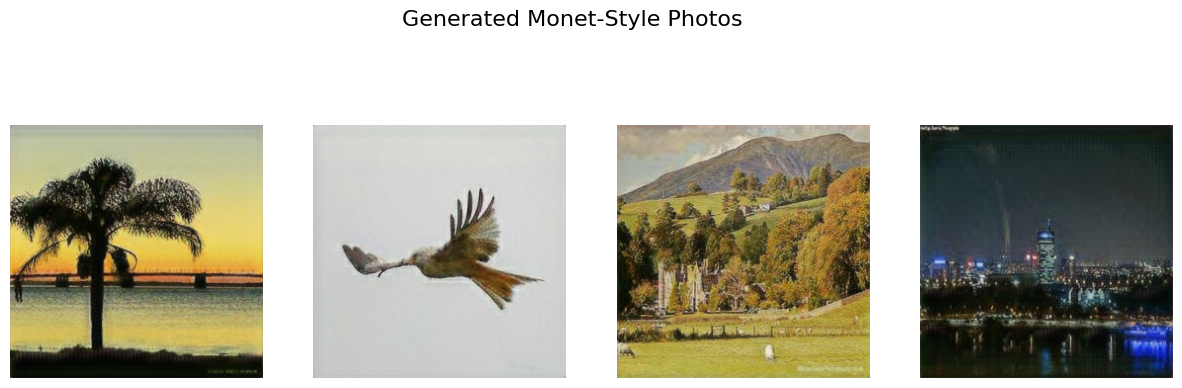

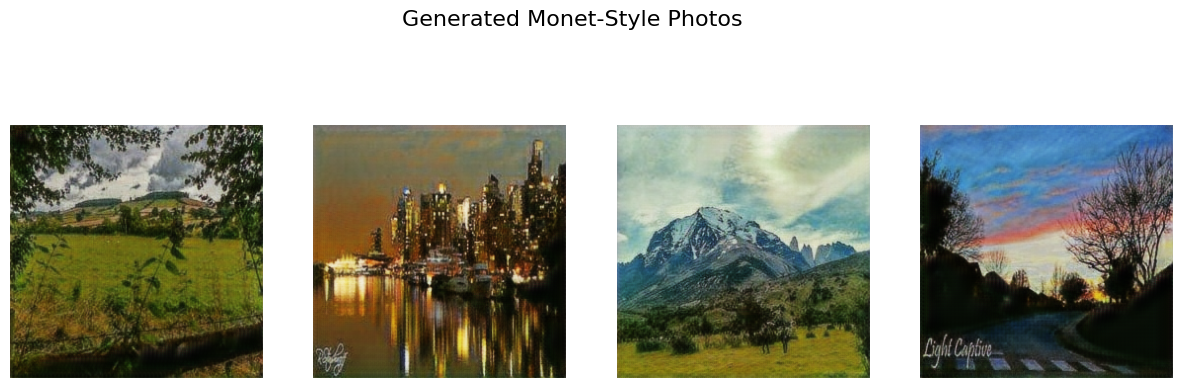

In [23]:
# Function to generate and show results
def generate_and_show_images(generator, loader, num_images=4):
    generator.eval()
    with torch.no_grad():
        for i, images in enumerate(loader):
            images = images.to(device)
            generated_images = generator(images)
            show_images([generated_images[j].cpu() for j in range(num_images)], title='Generated Monet-Style Photos')
            if i >= num_images // 4:
                break

generate_and_show_images(G_XtoY, photo_loader)

This approach ensures that we can visually inspect the performance of the model and verify that it is effectively transferring the Monet style to the photos.

### Conclusion

By following these steps, we’ve built and trained a CycleGAN using PyTorch to translate photos into Monet-style paintings. This approach leverages the power of unpaired image-to-image translation, making it suitable for tasks where paired datasets are unavailable. The use of CycleGAN ensures that the generated images not only adopt the desired style but also retain the original content and structure of the input images.